In [1]:
import os

FIRE_PATH = "/content/drive/My Drive/Colab Notebooks/DATA/FIRE"
ACC_PATH = "/content/drive/My Drive/Colab Notebooks/DATA/ACCIDENT"
ROB_PATH = "/content/drive/My Drive/Colab Notebooks/DATA/ROBBERY"
NORMAL_PATH = "/content/drive/My Drive/Colab Notebooks/DATA/NORMAL"

CLASSES = ["Normal", "Fire", "Accident", "Robbery"]

from google.colab import drive
drive.mount('/content/drive')


# define the size of the training and testing split
TRAIN_SPLIT = 0.75
TEST_SPLIT = 0.25

# define the initial learning rate, batch size, and number of epochs
INIT_LR = 1e-2
BATCH_SIZE = 64
NUM_EPOCHS = 3

Mounted at /content/drive


In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import sys

def load_dataset(datasetPath):
    # grab the paths to all images in our dataset directory, then
    # initialize our lists of images
    imagePaths = list(paths.list_images(datasetPath))
    data = []
    # loop over the image paths
    for imagePath in imagePaths:
        # load the image and resize it to be a fixed 128x128 pixels,
        # ignoring aspect ratio
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (128, 128))
        # add the image to the data lists
        data.append(image)
        # return the data list as a NumPy array
    return np.array(data, dtype="float32")


# ## DATA LOADING

# load the images
print("[INFO] loading normal data...")
normalData = load_dataset(NORMAL_PATH)
print("[INFO] loading fire data...")
fireData = load_dataset(FIRE_PATH)
print("[INFO] loading accident data...")
accidentData = load_dataset(ACC_PATH)
print("[INFO] loading robbery data...")
robberyData = load_dataset(ROB_PATH)

[INFO] loading normal data...
[INFO] loading fire data...
[INFO] loading accident data...
[INFO] loading robbery data...


<Figure size 640x480 with 0 Axes>

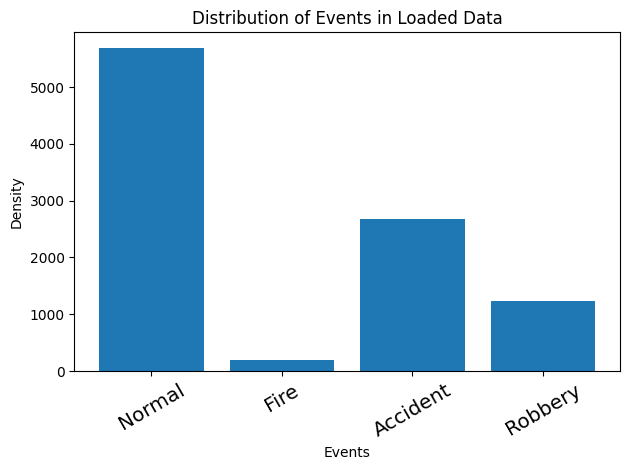

<Figure size 640x480 with 0 Axes>

In [ ]:
# ## DATA DISTRIBUTION PLOT

import matplotlib.pyplot as plt
import numpy as np
label = CLASSES
file_count = [normalData.shape[0],fireData.shape[0],accidentData.shape[0],robberyData.shape[0]]
index=np.arange(len(label))
plt.bar(index,file_count)
plt.xlabel('Events')
plt.ylabel('Density')
plt.xticks(index,label,rotation=30,fontsize = 'x-large')
plt.title('Distribution of Events in Loaded Data')
plt.tight_layout()
plt.savefig('train_data_distribution.pdf', format='pdf', dpi=1000)
#plt.style.use("ggplot")
plt.figure()


[INFO] Label created for all data...
[INFO] stacking data...


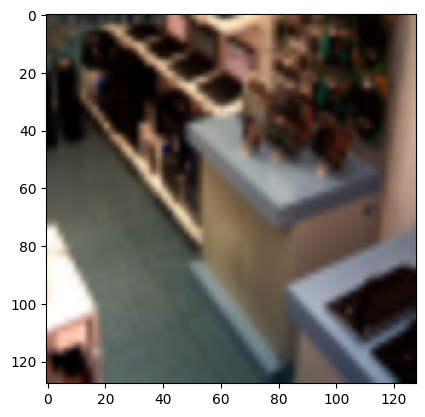

In [ ]:
# ## DATA ANALYSIS

# construct the class labels for the data
normalLabels = np.zeros((normalData.shape[0],))
fireLabels = np.ones((fireData.shape[0],))
accidentLabels = np.full(accidentData.shape[0],2)
robberyLabels = np.full(robberyData.shape[0],3)
print("[INFO] Label created for all data...")
labels = np.hstack([normalLabels, fireLabels, accidentLabels, robberyLabels])
labels = labels.astype(int)
# stack the fire data with the non-fire data
print("[INFO] stacking data...")
data = np.vstack([normalData, fireData, accidentData, robberyData])
data /= 255    #scale the data to the range [0, 1]



data.shape


labels.shape
pic = data[1101]
plt.grid(False)
plt.imshow(pic)



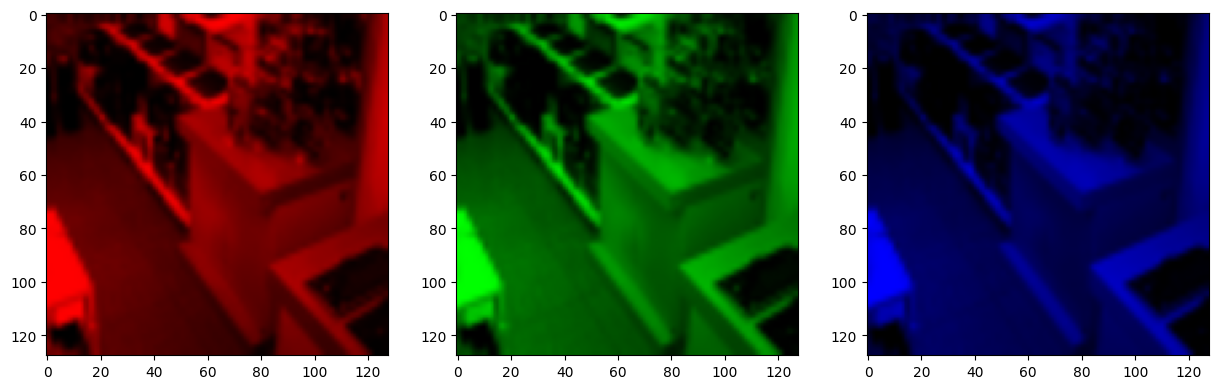

In [ ]:
# display each channel
import numpy as np
import keras
import keras.preprocessing.image
pic = data[1101]
fig, ax = plt.subplots(nrows = 1, ncols=3, figsize=(15,5))
for c, ax in zip(range(3), ax):
    # create zero matrix
    split_img = np.zeros(pic.shape, dtype="float32") # 'dtype' by default: 'numpy.float64'
    # assing each channel
    split_img[ :, :, c] = pic[ :, :, c]
    ax.grid(False)
    # display each channel
    ax.imshow(split_img)
plt.show()


In [ ]:
# perform one-hot encoding on the labels and account for skew in the labeled data
#labels = to_categorical(labels, num_classes=4)
classTotals = labels.sum(axis = 0)
classWeight = classTotals.max() / classTotals


# ## DATA TRAIN - TEST SPLIT

# construct the training and testing split
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size = TEST_SPLIT, random_state = 42)



trainX.shape



trainY.shape



testX.shape



testY.shape


(2447,)

In [ ]:
# ## MODEL BUILDING


# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD  # Import the SGD optimizer
import torch
import torch.nn as nn

class FireDetectionNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # CONV => RELU => POOL
        model.add(SeparableConv2D(16, (7, 7), padding="same",input_shape=inputShape, activation="relu"))
        #model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        # CONV => RELU => POOL
        model.add(SeparableConv2D(32, (3, 3), padding="same",activation="relu"))
        #model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        # (CONV => RELU) * 2 => POOL
        model.add(SeparableConv2D(64, (3, 3), padding="same",activation="relu"))
        #model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(SeparableConv2D(64, (3, 3), padding="same",activation="relu"))
        #model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        # first set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        # second set of FC => RELU layers
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        # return the constructed network architecture
        return model

model = FireDetectionNet.build(width = 128, height= 128, depth = 3, classes = 4)
model.summary()


from tensorflow.keras.optimizers import RMSprop
# initialize the optimizer and model
opt = SGD(lr= INIT_LR, momentum = 0.9)
opt_2 = RMSprop()
model.compile(loss = "sparse_categorical_crossentropy", optimizer = opt, metrics =["accuracy"])
print("[INFO] compiling model...")


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d_8 (Separa  (None, 128, 128, 16)      211       
 bleConv2D)                                                      
                                                                 
 batch_normalization_12 (Ba  (None, 128, 128, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 64, 64, 16)        0         
 g2D)                                                            
                                                                 
 separable_conv2d_9 (Separa  (None, 64, 64, 32)        688       
 bleConv2D)                                                      
                                                                 
 batch_normalization_13 (Ba  (None, 64, 64, 32)       

[INFO] compiling model...


In [ ]:
#Utilize callback to store the weights of the best model
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/DATA/best_weights_act_DWS.hdf5",
                               monitor = 'val_acc',
                               verbose=1,
                               save_best_only=1)


# train the network
print("[INFO] training network...")
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
tstart= datetime.datetime.now()
H = model.fit(trainX, trainY,
              validation_data=(testX, testY),
              epochs=NUM_EPOCHS,
              callbacks=[checkpointer])
tend= datetime.datetime.now()
timeTaken = tend-tstart
print("time for training(ms):",int(timeTaken.total_seconds()*1000))




Ttime=timeTaken
print("Time for 100 epochs:",
      Ttime.seconds//3600, "hours",
      (Ttime.seconds//60)%60,"minutes")


[INFO] training network...
Epoch 1/3
230/230 [==============================] - ETA: 0s - loss: 0.1882 - accuracy: 0.9413

230/230 [==============================] - 365s 2s/step - loss: 0.1882 - accuracy: 0.9413 - val_loss: 3.9481 - val_accuracy: 0.2697
Epoch 2/3
230/230 [==============================] - ETA: 0s - loss: 0.0263 - accuracy: 0.9939

230/230 [==============================] - 362s 2s/step - loss: 0.0263 - accuracy: 0.9939 - val_loss: 3.1392 - val_accuracy: 0.2799
Epoch 3/3
230/230 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9959

230/230 [==============================] - 352s 2s/step - loss: 0.0147 - accuracy: 0.9959 - val_loss: 0.0284 - val_accuracy: 0.9939
time for training(ms): 1106808
Time for 100 epochs: 0 hours 18 minutes


In [ ]:
#Load our classifier with the weights of the best model
#model.load_weights('/content/drive/My Drive/Colab Notebooks/DATA/best_weights_act_DWS.hdf5')

#Saving the complete model
model.save('/content/drive/My Drive/Colab Notebooks/DATA/activity_detection_DWS.h5')



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# ## TESTING AND EVALUATION

loss,acc = model.evaluate(testX,testY,verbose = 1)
print('Accuracy: %f'%(acc*100))



# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size = BATCH_SIZE)

print(classification_report(testY,
                            predictions.argmax(axis = 1),
                            target_names = CLASSES))

77/77 [==============================] - 41s 521ms/step - loss: 0.0116 - accuracy: 0.9971
Accuracy: 99.713933
[INFO] evaluating network...
39/39 [==============================] - 43s 1s/step
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      1461
        Fire       1.00      0.97      0.99        36
    Accident       0.99      1.00      0.99       660
     Robbery       1.00      0.98      0.99       290

    accuracy                           1.00      2447
   macro avg       1.00      0.99      0.99      2447
weighted avg       1.00      1.00      1.00      2447



<Figure size 640x480 with 0 Axes>

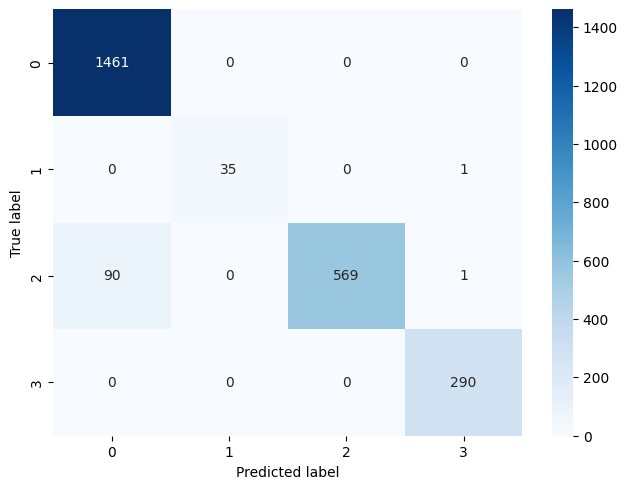

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
con_mat = confusion_matrix(testY, predictions.argmax(axis = 1))
#print(con_mat)
figure = plt.figure()
sns.heatmap(con_mat, annot=True, cmap=plt.cm.Blues,fmt="d")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.figure()

In [ ]:
# import the necessary packages
from tensorflow.keras.models import load_model
from imutils import paths
import numpy as np
import imutils
import random
import cv2
import os

# load the trained model from disk
print("[INFO] loading model...")
model = load_model('/content/drive/My Drive/Colab Notebooks/DATA/activity_detection_DWS.h5')


# ### Prediction from Video Input




def predict(path):
    #Load video
    from bokeh.plotting import figure
    from bokeh.io import output_notebook, show, push_notebook
    import cv2
    import time
    output_notebook()

    cap = cv2.VideoCapture(path)
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA) # because Bokeh expects a RGBA image
    frame = cv2.flip(frame, 0) # because Bokeh flips vertically
    width = frame.shape[1]
    height = frame.shape[0]
    p = figure(x_range=(0,width), y_range=(0,height), output_backend="webgl", width=700, height=400)
    myImage = p.image_rgba(image=[frame], x=0, y=0, dw=width, dh=height)
    label = []
    show(p, notebook_handle = True)

    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret==True:
            img = frame
            img = cv2.resize(img,(128, 128),interpolation=cv2.INTER_AREA)
            img = img.astype("float32") / 255.0
            preds = model.predict(np.expand_dims(img, axis=0))[0]
            j = np.argmax(preds)
            label = CLASSES[j]
            #print("Predicted Class : ",label)
            cv2.putText(frame, label, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,1.25, (0, 255, 0), 5)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
            frame = cv2.flip(frame, 0)
            myImage.data_source.data['image'] = [frame]
            push_notebook()
            if cv2.waitKey(1) & 0xFF == ord('q'): # press q to quit
                break
        else:
            break
        #time.sleep(0.2)
    cap.release()
    print('Detected Activity:', label)





predict(input('path:'))#/content/drive/My Drive/Colab Notebooks/DATA/ACCIDENT.mp4








[INFO] loading model...
path:/content/drive/My Drive/Colab Notebooks/DATA/ACCIDENT.mp4


1/1 [==============================] - 0s 63ms/step
